# Lecture 19: Convolutional Neural Networks (CNN) II cont

MTU Spring 2024

Instructor: Abel Reyes

### Announcements

- HW7 grades are in progress
- Quiz 3 grades in progress (yet)
- HW8 will be released this week (due next Wednesday)
- Midterm grades on canvas
- Final course project guidelines on canvas.
- Quiz 4 this Friday!


## Learning outcomes
- Understand several NN layers (CNN, FC, Pooling)
- Understand NN models in Pytorch (image classification)
- Understand NN models in keras (Segmentation task,  **transfer learning, image colorization** )

## Convolutional Neural Network (CNN)

A convolutional neural network (CNN) consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product. The activation function is commonly a REctified Linear Unit (RELU) layer, and is subsequently followed by additional convolutions such as pooling layers, fully connected layers and normalization layers, referred to as hidden layers because their inputs and outputs are masked by the activation function and final convolution. The final convolution, in turn, often involves backpropagation in order to more accurately weight the end product.

To recap, a CNN have

- Convolutional Layers
- Pooling Layers
- Fully Connected Layers
- Nornalization Layers where 2,3,4 are hidden layers.

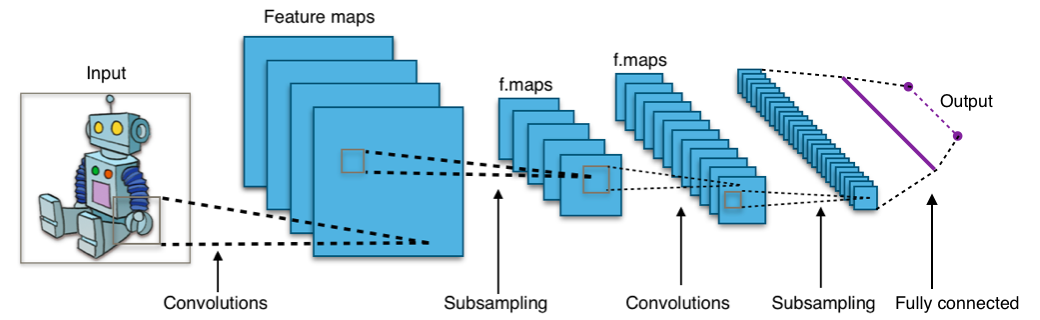

### Convolutional Layers

When programming a CNN, the input is a tensor with shape (number of images, (image width , image height), image depth). Then after passing through a convolutional layer, the image becomes abstracted to a feature map, with shape (number of images, (feature map width, feature map height) , feature map channels). A convolutional layer within a neural network should have the following attributes:

* Convolutional kernels defined by a width and height (hyper-parameters).
* The number of input channels and output channels (hyper-parameter).
* The depth of the Convolution filter (the input channels) must be equal to the number channels (depth) of the input feature map.


Convolutional layers convolve the input and pass its result to the next layer. The convolution operation brings a solution to the problem arising from the presence of a huge number of input data (i.e. the number of pixels) as it reduces the number of free parameters, allowing the network to be deeper with fewer parameters.

The convolutional layer is the core building block of a CNN. The layer's parameters consist of a set of learnable filters (or kernels), which have a small receptive field, but extend through the full depth of the input volume. During the forward pass, each filter is convolved across the width and height of the input volume, computing the dot product between the entries of the filter and the input and producing a 2-dimensional activation map of that filter. As a result, the network learns filters that activate when it detects some specific type of feature at some spatial position in the input.

Stacking the activation maps for all filters along the depth dimension forms the full output volume of the convolution layer. Every entry in the output volume can thus also be interpreted as an output of a neuron that looks at a small region in the input and shares parameters with neurons in the same activation map.

### Pooling

Convolutional networks may include local or global pooling layers to streamline the underlying computation. Pooling layers reduce the dimensions of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. Local pooling combines small clusters, typically 2 x 2.

Global pooling acts on all the neurons of the convolutional layer. In addition, pooling may compute a max or an average. Max pooling uses the maximum value from each of a cluster of neurons at the prior layer. Average pooling uses the average value from each of a cluster of neurons at the prior layer.

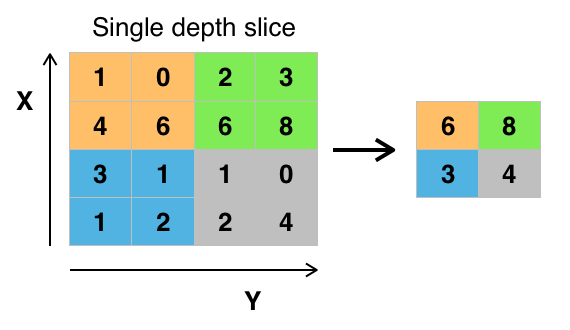


### Fully Connected Layers

**Fully connected**  layers connect every neuron in one layer to every neuron in another layer. It is in principle the same as the traditional multi-layer perceptron neural network (MLP). The flattened matrix goes through a fully connected layer to classify the images.

#### Receptive Fields
In neural networks, each neuron receives input from some number of locations in the previous layer. In a fully connected layer, each neuron receives input from every element of the previous layer. In a convolutional layer, neurons receive input from only a restricted subarea of the previous layer. Typically the subarea is of a square shape (e.g., size 5 by 5). The input area of a neuron is called its  **receptive field**.

So:

* in a **fully connected layer** , the receptive field is the entire previous layer.
* In a **convolutional layer** , the receptive area is smaller than the entire previous layer.

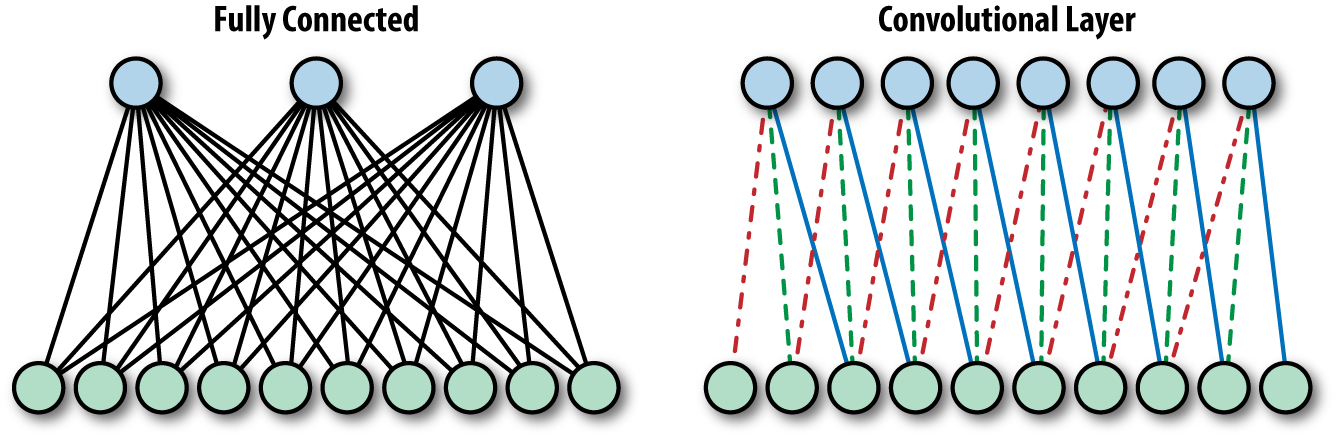

## Transfer Learning & Fine-tuning
[Source](https://keras.io/guides/transfer_learning/)



**Transfer learning**  consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

Take layers from a previously trained model.
Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
Train the new layers on your dataset.


A last, optional step, is **fine-tuning** , which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

First, we will go over the Keras trainable API in detail, which underlies most transfer learning & fine-tuning workflows.

Then, we'll demonstrate the typical workflow by taking a model pretrained on the ImageNet dataset, and retraining it on the Kaggle "cats vs dogs" classification dataset.

### The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.
Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on your data, rather than once per epoch of training. So it's a lot faster & cheaper.

An issue with that second workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance. Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important. So in what follows, we will focus on the first workflow.

Here's what the first workflow looks like in Keras:



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications



### First, instantiate a base model with pre-trained weights.

```
base_model = applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```


#### Then, freeze the base model.

```
base_model.trainable = False
```


#### Create a new model on top.
```
inputs = tf.keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
```


## Train the model on new data.

```
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## This is how to implement fine-tuning of the whole base model:
```
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

### An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset


In [2]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


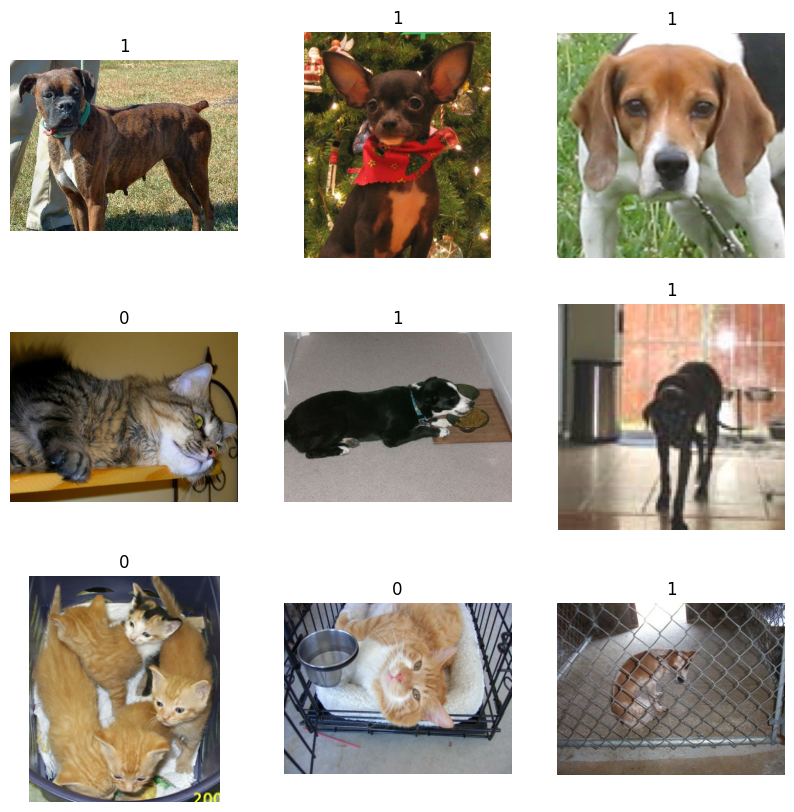

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [5]:
## Standardizing the data

resize_fn = tf.keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [6]:
## Using random data augmentation

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [7]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

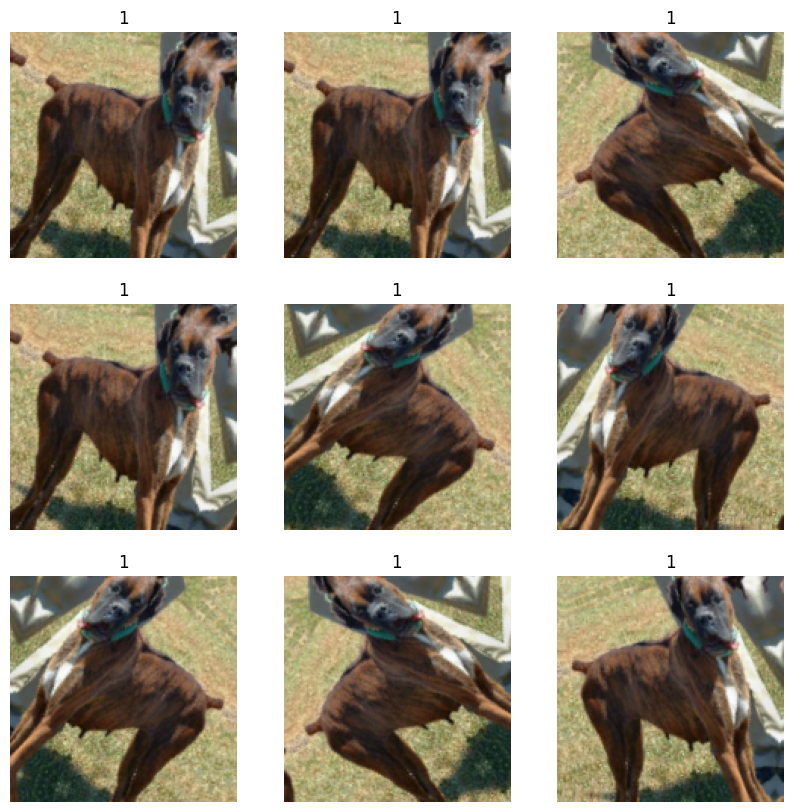

In [8]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [9]:
base_model = applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  N          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                             

### Train the top layer

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 [==============================] - 36s 211ms/step - loss: 0.2012 - binary_accuracy: 0.9088 - val_loss: 0.0899 - val_binary_accuracy: 0.9660
Epoch 2/2
146/146 [==============================] - 7s 47ms/step - loss: 0.1232 - binary_accuracy: 0.9470 - val_loss: 0.0822 - val_binary_accuracy: 0.9686


### Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [11]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)



Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  Y          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                             

In [13]:
epochs = 10
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the end-to-end model
Epoch 1/10
146/146 [==============================] - 191s 1s/step - loss: 0.0370 - binary_accuracy: 0.9869 - val_loss: 0.0563 - val_binary_accuracy: 0.9789
Epoch 2/10
146/146 [==============================] - 259s 2s/step - loss: 0.0161 - binary_accuracy: 0.9954 - val_loss: 0.0613 - val_binary_accuracy: 0.9798
Epoch 3/10
146/146 [==============================] - 294s 2s/step - loss: 0.0069 - binary_accuracy: 0.9986 - val_loss: 0.0760 - val_binary_accuracy: 0.9776
Epoch 4/10
146/146 [==============================] - 347s 2s/step - loss: 0.0036 - binary_accuracy: 0.9998 - val_loss: 0.0874 - val_binary_accuracy: 0.9768
Epoch 5/10
  5/146 [>.............................] - ETA: 4:01 - loss: 0.0017 - binary_accuracy: 1.0000  

KeyboardInterrupt: 

**After** 10 epochs, fine-tuning gains us a nice improvement here.
Let's evaluate the model on the test dataset:

In [14]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 [==============================] - 13s 347ms/step - loss: 0.0976 - binary_accuracy: 0.9776


[0.09761571884155273, 0.9776440262794495]

## Colorization Autoencoders using Keras

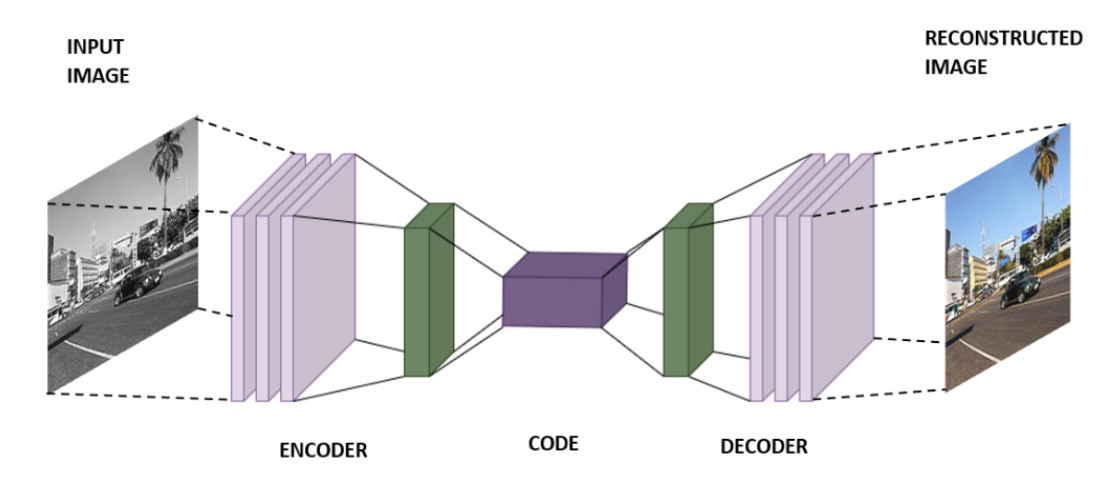

#### Encoder: 
This transforms the input into low-dimensional latent vector.As it reduces dimension, so it is forced to learn the most important features of the input. 
#### Decoder: 
This tries to reconstruct the input as much as possible from the latent vector.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
 
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar100
from keras import backend as K
from keras.optimizers import Adam


As the dataset contain only coloured images, so for the purpose of our task we need to change it to grayscale. We hence define a function for that. 

#### Code: Function to convert RGB images to Grayscale 

In [2]:
def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

#### Code: Load the dataset 

In [3]:
(x_train, _), (x_test, _) = cifar100.load_data()

In [4]:
x_train_gray=rgb_2_gray(x_train)
x_test_gray=rgb_2_gray(x_test)

#### Code: Normalize the data 

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
 
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

#### Code: Hyper-parameters 

In [10]:
input_shape = (x_train.shape[1], x_train.shape[2], 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
channels=3 #x_train.shape[-1]
layer_filters = [64, 128, 256]

#### Code: Encoder 

In [7]:
inputs = Input(shape = input_shape)
x = inputs
for filters in layer_filters:
    x = Conv2D(filters = filters,
           kernel_size = kernel_size,
           strides = 2,
           activation ='relu',
           padding ='same')(x)
 
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name ='latent_vector')(x)
encoder = Model(inputs, latent, name ='encoder')

In [8]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

#### Code: Decoder 

In [11]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-
# Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      strides = 2,
                      activation ='relu',
                      padding ='same')(x)
outputs = Conv2DTranspose(filters = channels,
                          kernel_size = kernel_size,
                          activation ='sigmoid',
                          padding ='same',
                          name ='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name ='decoder')

In [12]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              1052672   
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 64)       7379

#### Autoencoder

In [13]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name ='autoencoder')

In [15]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.compile(optimizer=Adam(), loss='mse')

In [22]:

# Define callbacks (optional)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    ModelCheckpoint("model.h5", save_best_only=True)
]

In [23]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data =(x_test_gray, x_test),
                epochs = 30,
                batch_size = batch_size,
                callbacks = callbacks
               )

Epoch 1/30
1563/1563 [==============================] - 16s 8ms/step - loss: 0.0191 - val_loss: 0.0146 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0136 - val_loss: 0.0132 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0126 - val_loss: 0.0124 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0119 - val_loss: 0.0120 - lr: 0.0010
Epoch 5/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0114 - val_loss: 0.0116 - lr: 0.0010
Epoch 6/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0117 - lr: 0.0010
Epoch 7/30
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0107 - val_loss: 0.0113 - lr: 0.0010
Epoch 8/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 0.0010
Epoch 9/30
1563/1563 [==============================] - 12s 8ms/step - l

#### Code: Results and analysis



In [24]:
### Getting some color to the images
colorizing=autoencoder.predict(x_test_gray)
colorizing.shape

313/313 [==============================] - 1s 4ms/step


(10000, 32, 32, 3)

In [25]:
def plot_images_grid(X_train, figsize=(10, 10)):
    """
    Plots a 6x6 grid of images from the X_train dataset.

    Parameters:
    - X_train: A dataset of images (numpy array).
    - figsize: Tuple indicating the size of the figure.
    """
    fig, axes = plt.subplots(6, 6, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(X_train):
            # Assuming images are in the range [0, 1]. If not, you might need to normalize them.
            ax.imshow(X_train[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes if there are no more images to display
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

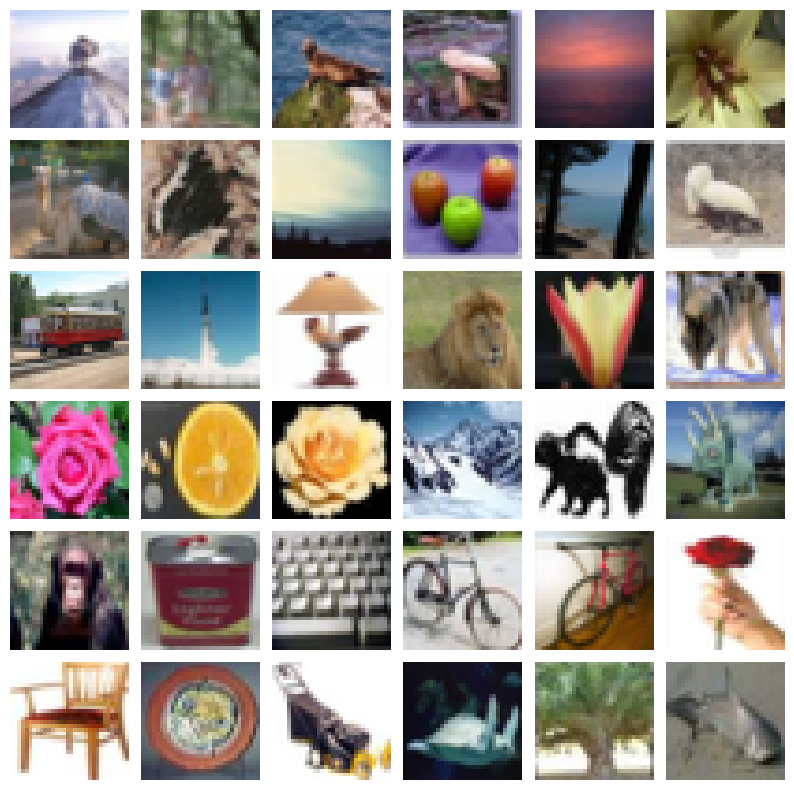

In [26]:
plot_images_grid(x_test)

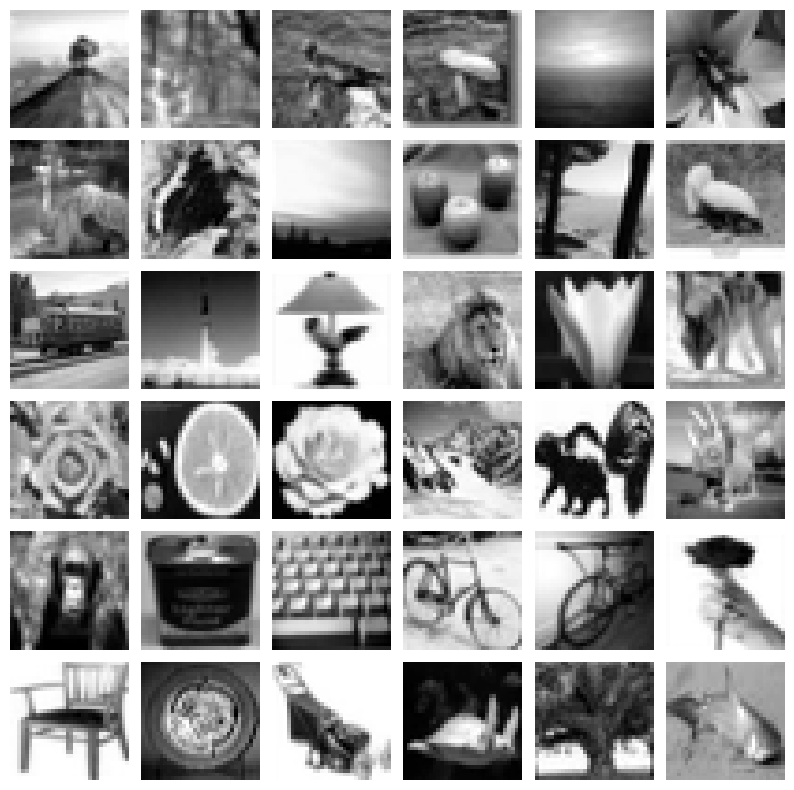

In [27]:
plot_images_grid(x_test_gray)

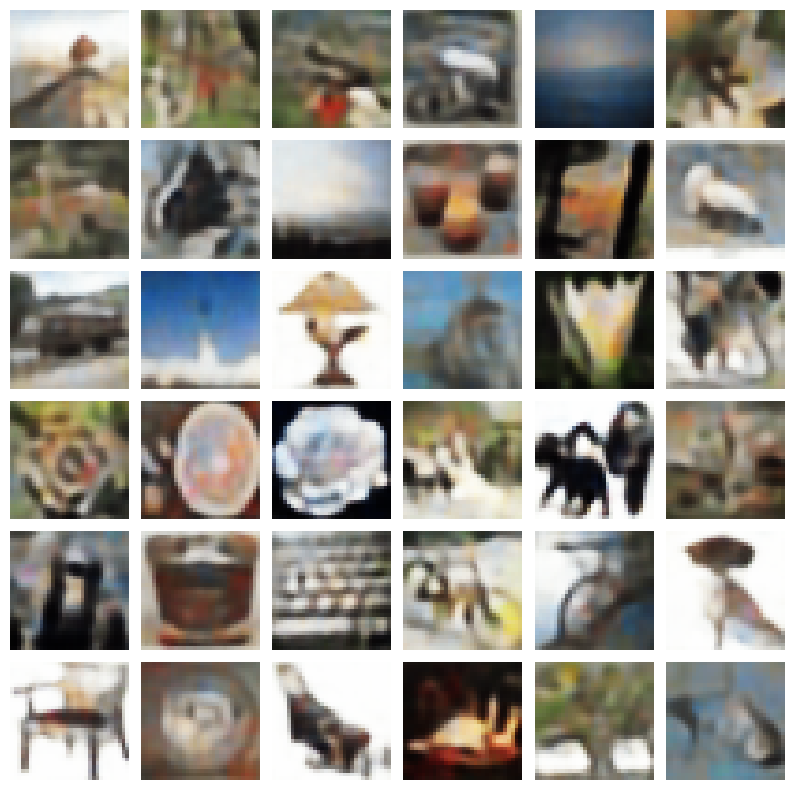

In [28]:
plot_images_grid(colorizing)

### Additional methods you want to check:
* Data Augmentation: https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
* Denoising models: https://keras.io/examples/vision/autoencoder/
* Data loaders and data generators: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly, https://www.tensorflow.org/tutorials/load_data/numpy, https://keras.io/api/data_loading/
* Callbacks in keras: Learning rate scheduler, early stopping, checkpoints...: https://keras.io/api/callbacks/